# In-silico derivatization

The notebook reads a list of SMILES (text file, one molecule per line), and performs in-silico MeOX + TMS derivatization (as described e.g. in https://doi.org/10.1021/acs.analchem.7b01010):

* Metoxymation: ketone R(C=O)R' and aldehyde karboxyl groups are substituted with C=NO[CH3]
* Trimethylsilylation: in -OH, -SH, -NH2, -NHR, =NH, the hydrogen is substituted with -SiMe3

The probability of all the substitutions can be adjusted, they needn't happen always. Multiple substitution attempts are run on each input molecule, and all distinct results are returned.

Known limitation is metoxymation on cycles which should be broken. This is not implemented yet.

The final outputs are two files:

* `derivs_struct.tsv` with columns (all SMILES):
  * original
  * with derivatization groups stripped
  * column #2 derivatized (multiple times) according to the above rules
* `derivs_flat.txt` -- the above with all the smiles flattened, one per line



### Import what we need and setup the environment

In [3]:
pip install py3Dmol

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from copy import deepcopy
import random

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 200,200

random.seed(42)

import multiprocessing
from concurrent.futures import ProcessPoolExecutor
cpus = multiprocessing.cpu_count()
print('# cpus (including HT, typically): ', cpus)

# don't run on HT cores, it just makes congestion
cpus //= 2

# cpus (including HT, typically):  112


### Utility function for 3D rendering

In [3]:
import py3Dmol

def draw3d(m,dimensions=(500,300),p=None):
    AllChem.EmbedMultipleConfs(m, clearConfs=True, numConfs=50)
    opt =  AllChem.MMFFOptimizeMoleculeConfs(m)
    conf = min(range(len(opt)),key = lambda x: opt[x][1] if opt[x][0] == 0 else float("inf") )
    
    mb = Chem.MolToMolBlock(m,confId=conf)
    if p is None:
        p = py3Dmol.view(width=dimensions[0],height=dimensions[1])
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

### The main functionality

All these functions take either RDKit molecule object or SMILES as argument.
`is_derivatized()` returns bool, the other two sanitized RDKit molecule.

In [4]:
tms = '[Si]([CH3])([CH3])[CH3]'

# XXX: ~[O,N,S] would match more than we aim to (-O, -S, -N, =N) but it's unlikely to happen
tms_match = Chem.MolFromSmarts('*~[O,N,S]' + tms)
tms_match0 = Chem.MolFromSmarts('[#0]([CH3])([CH3])[CH3]')

meox_match_co = Chem.MolFromSmarts('C([C,c])([C,c])=NO[CH3]')
meox_match_cho = Chem.MolFromSmarts('[CH]([C,c])=NO[CH3]')
meox_match0 = Chem.MolFromSmarts('[#0]=NO[CH3]')
co = Chem.MolFromSmiles('C=O')

def is_derivatized(mol=None,smiles=None):
    if mol is None:
        mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    return mol.HasSubstructMatch(tms_match) or mol.HasSubstructMatch(meox_match_co) or mol.HasSubstructMatch(meox_match_cho)

def remove_derivatization_groups(mol=None,smiles=None):
    if mol is None:
        em = Chem.MolFromSmiles(smiles)
    else:
        em = deepcopy(mol)
        
    matches = em.GetSubstructMatches(tms_match)
    for ma in matches:
        em.GetAtomWithIdx(ma[2]).SetAtomicNum(0)
    
    em = AllChem.DeleteSubstructs(em,tms_match0)
    
    matches = em.GetSubstructMatches(meox_match_co)
    for ma in matches:
        em.GetAtomWithIdx(ma[0]).SetAtomicNum(0)
    matches = em.GetSubstructMatches(meox_match_cho)
    for ma in matches:
        em.GetAtomWithIdx(ma[0]).SetAtomicNum(0)
        
    em, = AllChem.ReplaceSubstructs(em,meox_match0,co,replaceAll=True)
    Chem.SanitizeMol(em)
    return em

# (match pattern, dummy atom #, probability)
_subs = [
 ('[OH]', [100], [.95]),
 ('[SH]', [101], [.80]),
# matches also imine
 ('[NH]', [102], [.50]),
 ('[NH2]', [103,102], [.25, .5]),  
 ('C([C,c])([C,c])=O', [104], [.90]),
 ('[CH]=O', [104], [.90]),
]

# (dummy atom #, replacement)
_repls = [
    ('[#100]', 'O'+tms),
    ('[#101]', 'S'+tms),
    ('[#102]', 'N'+tms),
    ('[#103]', f'N({tms}){tms}'),
    ('[#104]=O', 'C=NO[CH3]'),
]

#repls = list(zip(
#    map(lambda n: Chem.MolFromSmarts(f'[#{n}]'),_repls),
#    map(Chem.MolFromSmiles,_repls.values())
#))

subs = [ (Chem.MolFromSmarts(pat), repls, probs) for pat,repls,probs in _subs]
repls = [ (Chem.MolFromSmarts(pat), Chem.MolFromSmiles(repl)) for pat,repl in _repls]



def add_derivatization_groups(mol=None,smiles=None):
    if mol is None:
        mol = Chem.MolFromSmiles(smiles)
        
    em = deepcopy(mol)

    for pat,reps,probs in subs:
        matches = em.GetSubstructMatches(pat)
#        print(matches)
        for m in matches:
            r = random.random()
            for repl,prob in zip(reps,probs):
                if r < prob: 
                    em.GetAtomWithIdx(m[0]).SetAtomicNum(repl)
                    break
                    
    for pat,repl in repls:
#       print(Chem.MolToSmiles(pat),Chem.MolToSmiles(repl),Chem.MolToSmiles(em))
        em, = AllChem.ReplaceSubstructs(em,pat,repl,replaceAll=True)
        
    try:
        Chem.SanitizeMol(em)
        return em    
    
    except:
        print("SatnitizeMol() fails:", smiles if smiles else Chem.MolToSmiles(mol))
        return mol
        

### Simple checks on manual inputs

In [5]:
for s in ['CCC(=NOC)C', 'CCC=NOC', 'C=NOC', 'CSi(C)(C)C']:
    print(s,is_derivatized(smiles='CCC(=NOC)C'))

CCC(=NOC)C True
CCC=NOC True
C=NOC True
CSi(C)(C)C True


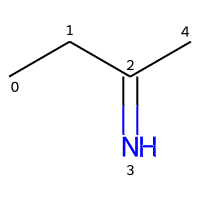

In [6]:
remove_derivatization_groups(smiles='CCC(=N)C')

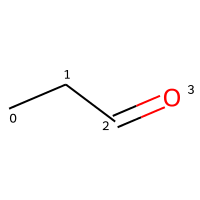

In [7]:
m=Chem.MolFromSmiles('CCC=NOC')
remove_derivatization_groups(m)

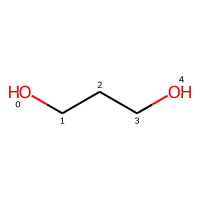

In [8]:
remove_derivatization_groups(smiles='C[Si](C)(C)OCCCO[Si](C)(C)C')

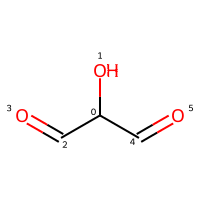

In [9]:
m=remove_derivatization_groups(smiles='CON=CC(O)C=NOC')
m

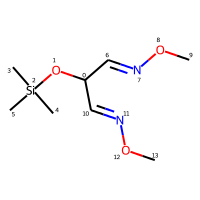

In [10]:
add_derivatization_groups(m)

### Read the input file

The file is parsed line by line, errors are reported and ignored otherwise. 

The result is `mol[]`, a list of pairs (_original SMILES_, _RDKit molecule_)

In [11]:
!pwd

/auto/brno6/home/ahajek/Spektro/MassGenie/data


In [12]:
#smi_file='NIST_Si_100.txt'
#smi_file='NIST_Si_all.txt'
#smi_file='NIST_SMILES.txt'
smi_file='trial_set/1M.smi'

# ADAM upravil, aby sedelo jeho datum
with open(smi_file) as f:
    f.readline() # only to skip the first line
    mols = list(filter(lambda p: p[1], [ (line.split(" ")[0].rstrip(), Chem.MolFromSmiles(line.split(" ")[0])) for line in f ]))

### Essential statistics

Count occurrences of (one-),di-,tri-methylsilane, TMS attached to -O, -N, -S, and methoximine. 

In [13]:
SiMe1=Chem.MolFromSmarts('[Si][CH3]')
SiMe2=Chem.MolFromSmarts('[Si]([CH3])[CH3]')
SiMe3=Chem.MolFromSmarts('[Si]([CH3])([CH3])[CH3]')
ONSSi=Chem.MolFromSmarts('[O,N,S][Si]([CH3])([CH3])[CH3]')

print('# total',len(mols))
with_sime1 = list(filter(lambda m: m[1].HasSubstructMatch(SiMe1),mols))
print("# with SiMe:", len(with_sime1))
with_sime2 = list(filter(lambda m: m[1].HasSubstructMatch(SiMe2),mols))
print("# with SiMe2:", len(with_sime2))
with_sime3 = list(filter(lambda m: m[1].HasSubstructMatch(SiMe3),mols))
print("# with SiMe3:", len(with_sime3))
with_onssi = list(filter(lambda m: m[1].HasSubstructMatch(ONSSi),mols))
print("# with ONSSi:", len(with_onssi))

MeOX=Chem.MolFromSmarts('C=NO[CH3]')
with_meox = list(filter(lambda m: m[1].HasSubstructMatch(MeOX),mols))
print("# with MeOX:", len(with_meox))




NameError: name 'mols' is not defined

### Inspect whatever from the sorted categories

In [ ]:
with_sime2[70][1]

In [ ]:
draw3d(with_sime2[70][1])

In [ ]:
draw3d(with_onssi[52][1])

In [ ]:
with_meox[4][1]

In [ ]:
with open('NIST_ONSSiMe3.txt','w') as f:
    for m in with_onssi:
        f.write(m[0]+'\n')
        
with open('NIST_SiMe3.txt','w') as f:
    for m in with_sime3:
        f.write(m[0]+'\n')
        
with open('NIST_MeOX.txt','w') as f:
    for m in with_meox:
        f.write(m[0]+'\n')

In [ ]:
#test_smi='CCO[Si](C)(C)C'
#test_smi='C[Si](C)(C)OCC-N[Si](C)(C)C'
#test_m = Chem.MolFromSmiles(test_smi)
test_m = with_onssi[35][1]
Chem.AddHs(test_m)
test_m

In [ ]:
test_n = remove_derivatization_groups(test_m)
Chem.AddHs(test_n)

In [ ]:
test_d = add_derivatization_groups(test_n)
test_d

In [ ]:
draw3d(test_d)

### Run the in-silico derivatization

Iterate over the `mol[]` list (read from file above), remove derivatization groups from each entry, and try derivatization several times to leverage from the probabilistic behaviour). Assemble the results.

This can be time consuming, expect about 5,000 entries per minute per core. Memory consumption can also grow to several GB.

In [ ]:
%%time
def process_one_mol(mol):
    return (
        mol[0],
        Chem.MolToSmiles(remove_derivatization_groups(mol[1])),
        { Chem.MolToSmiles(add_derivatization_groups(mol[1])) for _ in range(42) }
        )
        
with ProcessPoolExecutor(max_workers=cpus) as executor:
    out = executor.map(process_one_mol,mols)
    
out = list(out)

### Write the main outputs

In [ ]:
with open('derivs_struct.tsv','w') as tsv:
    tsv.write("orig\tderiv. removed\tderiv. added ...\n")
    for orig,removed,added in out:
        tsv.write("\t".join([orig,removed,*added]) + "\n")

In [ ]:
with open('derivs_flat.txt','w') as flat:
    for orig,removed,added in out:
        for one in { orig, removed, *added }:
            flat.write(one + "\n")